# PGF5005 — Mecânica Clássica · Itens 4.3 e 4.4  
**Pêndulo simples com *Euler simplético* (Euler–Cromer)**

Neste caderno implementamos, de forma modularizada e comentada, o método **Euler simplético** para o pêndulo simples adimensional com
$$
H(q,p) = \frac{p^2}{2} - \cos q.
$$

Do texto (seção 2.2), para Hamiltonianas separáveis \(H(q,p)=K(p)+U(q)\), o **Euler simplético** é:
$$
\boxed{
\begin{aligned}
q^{(n+1)} &= q^{(n)} + \Delta t\,\frac{\partial H}{\partial p}\big|_{p^{(n)}} = q^{(n)} + \Delta t\,p^{(n)},\\[2pt]
p^{(n+1)} &= p^{(n)} - \Delta t\,\frac{\partial H}{\partial q}\big|_{q^{(n+1)}} = p^{(n)} - \Delta t\,\sin\!\big(q^{(n+1)}\big).
\end{aligned}}
$$

No **item 4.3**, vamos gerar, para **dois conjuntos de condições iniciais** (librar e rotacionar), os gráficos $q(t)\times t$ e $p(t)\times t$ usando
$\Delta t \in \{10^{-1},10^{-2},10^{-3}\}$ — as **três curvas no mesmo gráfico** para comparar.

No **item 4.4**, verificamos numericamente a energia total do sistema, isto é, traçamos $E(t)\times t$ para as mesmas condições e passos de tempo.


## 1) Imports e utilidades

In [1]:
# Requisitos: numpy e matplotlib (sem seaborn, sem estilos)
import math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass


## 2) Modelo do pêndulo e funções auxiliares

- $\dot q = \partial H/\partial p = p$
- $\dot p = -\,\partial H/\partial q = -\sin q$ 
- $H(q,p) = \tfrac{1}{2}p^2 - \cos q$

A **separatriz** (limite entre librar e rotacionar) ocorre na energia $H=+1$.


In [2]:
def dq_dt(q, p):
    """dq/dt para o pêndulo simples: p."""
    return p

def dU_dq(q):
    """derivada de U(q) = -cos(q): dU/dq = sin(q)."""
    return math.sin(q)

def H(q, p):
    """Hamiltoniana H = p^2/2 - cos(q)."""
    return 0.5*p*p - math.cos(q)

def classify_energy(q, p, eps=1e-9):
    """Classifica o regime pela energia: libration (-1 < H < 1) ou rotation (H > 1)."""
    E = H(q, p)
    if E > 1 + eps:
        return "rotation", E
    elif E < 1 - eps:
        return "libration", E
    return "separatrix", E


## 3) **Um passo** de Euler simplético (Euler–Cromer)

Seguindo a ordem **q-avança com $p^{(n)}$** e **p-avança com $q^{(n+1)}$**,
preservando o caráter simplético do mapa numérico.


In [3]:
def euler_symplectic_step(q, p, dt):
    # 1) avança posição usando p^n
    q_next = q + dt * dq_dt(q, p)  # = q + dt * p
    # 2) avança momento usando q^{n+1}
    p_next = p - dt * dU_dq(q_next)  # = p - dt * sin(q^{n+1})
    return q_next, p_next


## 4) Integrador no intervalo \([0,T]\)

Armazenamos \((t,q,p,E)\) para traçar os gráficos de \(q(t)\), \(p(t)\) e \(E(t)\).


In [4]:
def integrar_symplectic(q0, p0, dt, T):
    n_steps = int(np.ceil(T/dt))
    t = np.empty(n_steps+1)
    q = np.empty(n_steps+1)
    p = np.empty(n_steps+1)
    E = np.empty(n_steps+1)
    # estado inicial
    t[0] = 0.0
    q[0] = q0
    p[0] = p0
    E[0] = H(q0, p0)
    # iteração temporal
    for n in range(n_steps):
        q[n+1], p[n+1] = euler_symplectic_step(q[n], p[n], dt)
        t[n+1] = (n+1)*dt
        E[n+1] = H(q[n+1], p[n+1])
    return t, q, p, E


## 5) Funções de plotagem (uma figura por gráfico)

Cada gráfico recebe as **três curvas** (um para cada $\Delta t$), com *labels* na legenda.


In [5]:
def plot_series_same_axes(series_list, xlab, ylab, title):
    """series_list: lista de tuplas (x, y, label)."""
    plt.figure()
    for x, y, label in series_list:
        plt.plot(x, y, label=label, lw=1.2)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.show()


## 6) Execução de cenários (librar e rotacionar)

- **Librar (oscilação):** escolher $(q_0,p_0)$ com $H<1$.  
  Ex.: $q_0=0.5,\ p_0=0\Rightarrow H\approx -0.8776$.

- **Rotacionar:** escolher $(q_0,p_0)$ com $H>1$.  
  Ex.: $q_0=0,\ p_0=2.2\Rightarrow H=2.2^2/2-1=1.42>1$.


In [6]:
# parâmetros comuns
dt_list = [1e-1, 1e-2, 1e-3]
T = 30.0  # tempo total de simulação (ajuste se desejar)

# condições iniciais
libration_ic = dict(q0=0.5, p0=0.0, nome="Librar (q0=0.5, p0=0.0)")
rotation_ic  = dict(q0=0.0, p0=2.2, nome="Rotacionar (q0=0.0, p0=2.2)")

def rodar_cenario(ic, dt_vals=dt_list, T_sim=T):
    modo, E0 = classify_energy(ic['q0'], ic['p0'])
    print(f"Cenário: {ic['nome']} — regime: {modo},  E0={E0:.6f}")
    resultados = {}
    for dt in dt_vals:
        t, q, p, E = integrar_symplectic(ic['q0'], ic['p0'], dt, T_sim)
        resultados[dt] = (t, q, p, E)
    return resultados

def graficos_item_4_3(nome, resultados):
    # q(t) x t
    series_q = [(t, q, f"dt={dt:g}") for dt, (t,q,p,E) in resultados.items()]
    plot_series_same_axes(series_q, "t", "q(t)", f"4.3 — {nome}: q(t) para 3 passos dt")
    # p(t) x t
    series_p = [(t, p, f"dt={dt:g}") for dt, (t,q,p,E) in resultados.items()]
    plot_series_same_axes(series_p, "t", "p(t)", f"4.3 — {nome}: p(t) para 3 passos dt")

def graficos_item_4_4(nome, resultados):
    # E(t) x t
    series_E = [(t, E, f"dt={dt:g}") for dt, (t,q,p,E) in resultados.items()]
    plot_series_same_axes(series_E, "t", "E(t)", f"4.4 — {nome}: Energia para 3 passos dt")


## 7) Rodando **librar** e **rotacionar** e gerando os gráficos solicitados

Cada item abaixo produz **dois gráficos** para 4.3 $[q(t),p(t)]$ e **um gráfico** para 4.4 $[E(t)]$, cada um com as três curvas de $\Delta t$.


Cenário: Librar (q0=0.5, p0=0.0) — regime: libration,  E0=-0.877583


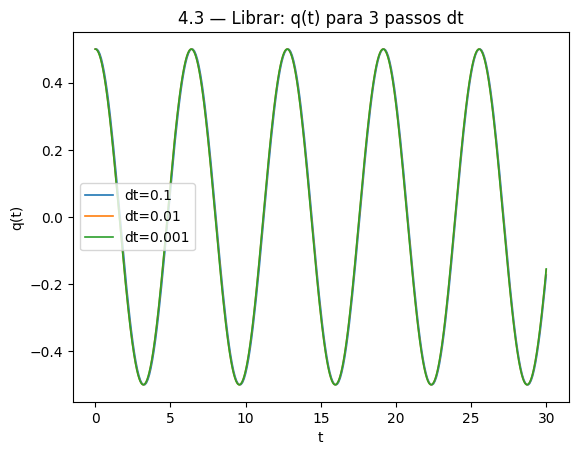

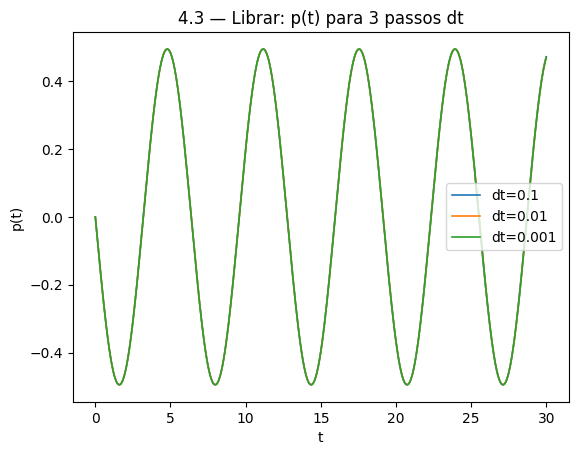

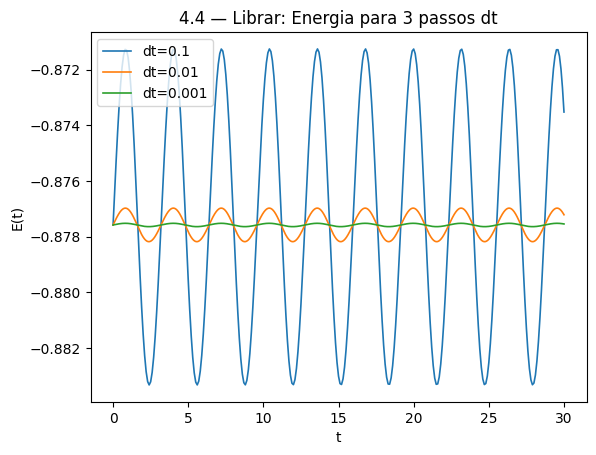

Cenário: Rotacionar (q0=0.0, p0=2.2) — regime: rotation,  E0=1.420000


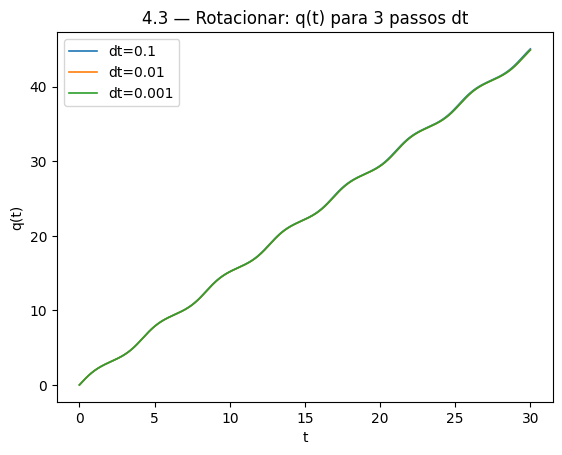

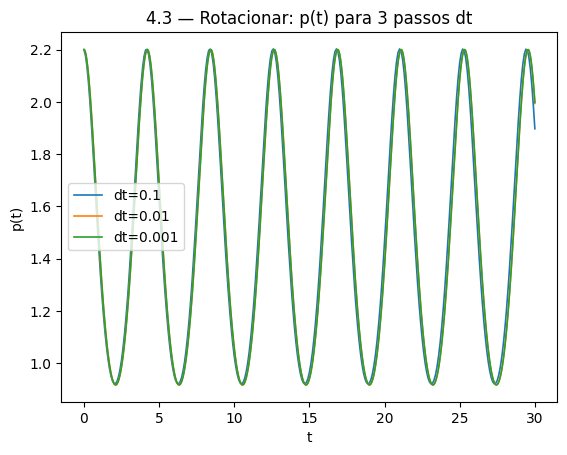

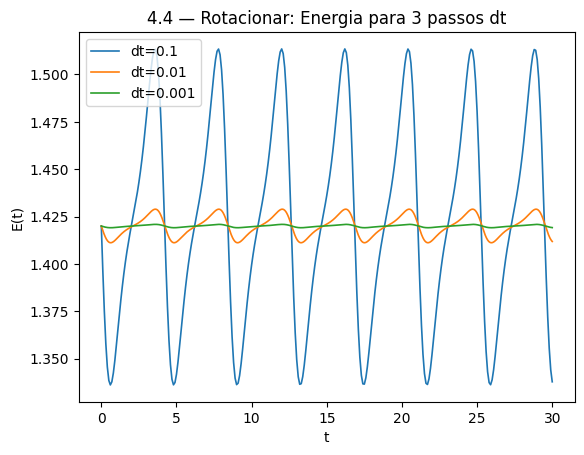

In [7]:
# --- Librar ---
res_lib = rodar_cenario(libration_ic)
graficos_item_4_3("Librar", res_lib)
graficos_item_4_4("Librar", res_lib)

# --- Rotacionar ---
res_rot = rodar_cenario(rotation_ic)
graficos_item_4_3("Rotacionar", res_rot)
graficos_item_4_4("Rotacionar", res_rot)


---
## 8) Notas para interpretação dos resultados (para o relatório)

- Com o **Euler simplético**, a energia **não é exatamente constante**, mas tende a ficar **quase-conservada**,
  oscilando em torno de um valor médio sem *drift* sistemático para $\Delta t$ suficientemente pequeno.
- Para a condição **librar**, $q(t)$ é aproximadamente periódico e $p(t)$ alterna sinal.
- Para a condição **rotacionar**, $q(t)$ cresce (ou decresce) monotonicamente no tempo (o pêndulo dá voltas) e $p(t)$
  oscila em torno de valores diferentes de zero.  
- Reduzindo $\Delta t$ (de $10^{-1}$ para $10^{-3}$), as curvas convergem e as oscilações de $E(t)$ diminuem.
- Se desejar, você pode **embrulhar o ângulo** com `q_wrapped = ( (q+pi) % (2*pi) ) - pi` apenas para visualização;
  aqui mantivemos $q(t)$ cru, como solicitado.

> Dica: para anexar ao trabalho, salve cada figura com `plt.savefig("nome.png", dpi=200, bbox_inches="tight")` logo antes de `plt.show()`.
